## Сравнительный анализ доходности тарифов сотовой связи

#### Описание проекта:

Клиентам федерального оператора сотовой связи «Мегалайна» предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег. Для этого необходимо сделать предварительный анализ тарифов на небольшой выборке клиентов. В нашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

#### Структура исследования:
- [1. Загрузка данных и ознакомление с ними](#1)
  - [Таблица tariffs](#1.1)
  - [Таблица users](#1.2)
  - [Таблица calls](#1.3)
  - [Таблица messages](#1.4)
  - [Таблица internet](#1.5)
- [2. Предобработка данных](#2)
  - [Обработка столбцов с датами](#2.1)
  - [Округление столбцов с продолжительностью звонков и интернет-трафиком](#2.8)   
  - [Удаление ненужных столбцов](#2.2)  
  - [Расчёт количества звонков для каждого пользователя](#2.3)
  - [Расчёт израсходованных минут для каждого пользователя](#2.4)
  - [Расчёт количества отправленных сообщений для каждого пользователя](#2.5)
  - [Расчёт израсходованного трафика для каждого пользователя](#2.6)
  - [Расчёт выручки, полученной с каждого пользователя](#2.7)
- [3. Анализ данных](#3)
  - [Динамика изменения количества клиентов по месяцам](#3.2)
  - [Топ городов по количеству клиентов](#3.3)
  - [Взаимосвязь тарифа и продолжительности звонков](#3.4)
  - [Взаимосвязь тарифа и количества отправленных сообщений](#3.5) 
  - [Взаимосвязь тарифа и интернет-трафика за одну сессию](#3.6) 
- [4. Проверка гипотез](#4)
  - [Средняя выручка клиентов тарифов «Ультра» и «Смарт» различается](#4.1)
  - [Средняя выручка клиентов из Москвы отличается от выручки клиентов из других регионов](#4.2)  
- [5. Общий вывод](#5)

#### 1. Загрузка данных и ознакомление с ними <a class="anchor" id="1"></a>

Загрузим библиотеки для работы с таблицами, графиками и статистическими параметрами:

In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats as st
import statistics as stat

#### Таблица tariffs <a class="anchor" id="1.1"></a>

Загрузим таблицу users c информацией о тарифах и посмотрим на неё:

In [2]:
tariffs = pd.read_csv('/Users/polzovatel/Downloads/tariffs.csv')

Датасет с данными можно скачать с google диска, он размещён [здесь](https://drive.google.com/drive/folders/1pqXhsZ7UYN959awQI6DhXjLYcbx640BM?usp=sharing).

In [3]:
tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Таблица tariffs (информация о тарифах):
- tariff_name — название тарифа
- rub_monthly_fee — ежемесячная абонентская плата в рублях
- minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
- messages_included — количество сообщений в месяц, включённых в абонентскую плату
- mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
- rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
- rub_per_message — стоимость отправки сообщения сверх тарифного пакета
- rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

У оператора два тарифа - smart и ultra. Первый - более простой и стоит дешевле, второй - продвинутый и дорогой.

#### Таблица users <a class="anchor" id="1.2"></a>

Загрузим таблицу users c информацией о клиентах и посмотрим на неё:

In [4]:
users = pd.read_csv('/Users/polzovatel/Downloads/users.csv')

In [5]:
users.sample(5)

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
492,1492,63,NaN,Санкт-Петербург,Руслана,Артёменко,2018-06-26,smart
419,1419,19,NaN,Новороссийск,Эльмира,Яшина,2018-07-19,smart
451,1451,58,NaN,Набережные Челны,Виктория,Завьялова,2018-08-27,smart
128,1128,51,2018-12-23,Волжский,Ксения,Агаева,2018-12-15,ultra
300,1300,40,NaN,Москва,Тихон,Азерников,2018-07-26,ultra


Таблица users (информация о пользователях):
- user_id — уникальный идентификатор пользователя
- first_name — имя пользователя
- last_name — фамилия пользователя
- age — возраст пользователя (годы)
- reg_date — дата подключения тарифа (день, месяц, год)
- churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
- city — город проживания пользователя
- tariff — название тарифного плана

Оценим пропуски и типы данных в столбцах:

In [6]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   user_id     500 non-null    int64 
 1   age         500 non-null    int64 
 2   churn_date  38 non-null     object
 3   city        500 non-null    object
 4   first_name  500 non-null    object
 5   last_name   500 non-null    object
 6   reg_date    500 non-null    object
 7   tariff      500 non-null    object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


Посмотрим на статистические характиристики данных:

In [7]:
users.describe().T

,count,mean,std,min,25%,50%,75%,max
user_id,500.0,1249.500,144.481833,1000.0,1124.75,1249.5,1374.25,1499.0
age,500.0,46.588,16.667630,18.0,32.00,46.0,62.00,75.0


In [8]:
users.describe(include='O').T

,count,unique,top,freq
churn_date,38,33,2018-12-09,2
city,500,76,Москва,99
first_name,500,246,Радим,6
last_name,500,419,Андреенко,5
reg_date,500,270,2018-05-28,8
tariff,500,2,smart,351


Узнаем количество уникальных клиентов в таблице:

In [9]:
users['user_id'].nunique()

500

Оценим распределение пользователей по возрастам:

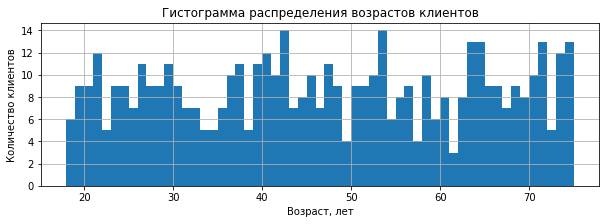

In [10]:
users['age'].hist(bins=57, figsize=(10, 3))
plt.title("Гистограмма распределения возрастов клиентов")
plt.xlabel("Возраст, лет")
plt.ylabel("Количество клиентов")
plt.show()

Посмотрим, за какой период времени предоставлены данные:

In [11]:
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d')
users['reg_date'].min(), users['reg_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

In [12]:
users['churn_date'] = pd.to_datetime(users['churn_date'], format='%Y-%m-%d')
users['churn_date'].min(), users['churn_date'].max()

(Timestamp('2018-08-17 00:00:00'), Timestamp('2018-12-30 00:00:00'))

После первоначального знакомства с таблицей users можно сделать следующие заключения:
- в таблице 8 столбцов и 500 строк;
- данные предоставлены за 2018 год, начиная с 1 января и заканчивая 31 декабря;
- в столбце user_id все значения уникальны - это значит, что таблица содержит информацию о 500 уникальных клиентах;
- много пропусков в столбце churn_date - эти клиенты не прекратили пользоваться тарифами;
- 38 клиентов прекратили пользоваться тарифами;
- клиенты оператора живут в 76 городах, больше всего - в Москве;
- тарифом smart пользуются 351 клиент, тарифом ultra - 149 клиентов;
- возрасты клиентов колеблются от 18 до 75 лет, распределение возрастов равномерное.

#### Таблица calls <a class="anchor" id="1.3"></a>

Загрузим таблицу calls c информацией о звонках клиентов и посмотрим на неё:

In [13]:
calls = pd.read_csv('/Users/polzovatel/Downloads/calls.csv')

In [14]:
calls.head(5)

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


Таблица calls (информация о звонках):
- id — уникальный номер звонка
- call_date — дата звонка
- duration — длительность звонка в минутах
- user_id — идентификатор пользователя, сделавшего звонок

Оценим пропуски и типы данных в столбцах:

In [15]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


Посмотрим на статистические характиристики данных:

In [16]:
calls.describe().T

,count,mean,std,min,25%,50%,75%,max
duration,202607.0,6.755887,5.843365,0.0,1.3,6.0,10.7,38.0
user_id,202607.0,1253.940619,144.722751,1000.0,1126.0,1260.0,1379.0,1499.0


In [17]:
calls.describe(include='O').T

,count,unique,top,freq
id,202607,202607,1290_61,1
call_date,202607,365,2018-12-31,1435


Узнаем количество уникальных клиентов в таблице:

In [18]:
calls['user_id'].nunique()

492

Посмотрим, за какой период времени предоставлены данные:

In [19]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d')
calls['call_date'].min(), calls['call_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

Построим гистограмму продолжительности звонков:

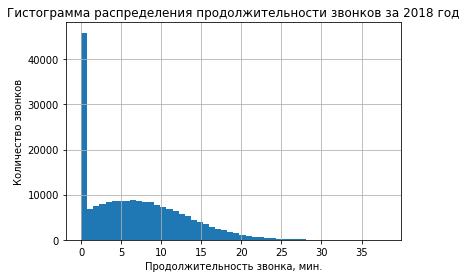

In [20]:
calls['duration'].hist(bins=50)
plt.title("Гистограмма распределения продолжительности звонков за 2018 год")
plt.xlabel("Продолжительность звонка, мин.")
plt.ylabel("Количество звонков")
plt.show()

Видно, что много звонков длятся 0 минут. Оценим их количество - абсолютное и относительное:

In [21]:
len(calls.query('duration == 0')), (len(calls) - len(calls.query('duration > 0'))) / len(calls)

(39613, 0.19551644316336553)

После первоначального знакомства с таблицей calls можно сделать следующие заключения:
- в таблице 4 столбца и 202 697 строк;
- данные предоставлены за 2018 год, начиная с 1 января и заканчивая 31 декабря;
- в столбце user_id только 492 уникальных клиента, то есть оставшиеся 8 клиентов из 500 не звонили в течение года;
- длительность 39 613 звонков (или 20%) — 0 минут. Это могут быть пропущенные звонки;
- распределение продолжительности состоявшихся звонков похоже на распределение Пуассона;
- среднее время звонков (с учетом пропущенных) - 6,8 минуты;
- больше всего звонков было совершено 31 декабря - накануне нового года.

#### Таблица messages <a class="anchor" id="1.4"></a>

Загрузим таблицу messages c информацией о сообщениях клиентов и посмотрим на неё:

In [22]:
messages = pd.read_csv('/Users/polzovatel/Downloads/messages.csv')

In [23]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


Таблица messages (информация о сообщениях):
- id — уникальный номер сообщения
- message_date — дата сообщения
- user_id — идентификатор пользователя, отправившего сообщение

Оценим пропуски и типы данных в столбцах:

In [24]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   id            123036 non-null  object
 1   message_date  123036 non-null  object
 2   user_id       123036 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


Посмотрим на статистические характиристики данных:

In [25]:
messages.describe(include='O').T

,count,unique,top,freq
id,123036,123036,1257_634,1
message_date,123036,364,2018-12-31,859


Узнаем количество уникальных клиентов в таблице:

In [26]:
messages['user_id'].nunique()

426

Посмотрим, за какой период времени предоставлены данные:

In [27]:
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d')
messages['message_date'].min(), messages['message_date'].max()

(Timestamp('2018-01-02 00:00:00'), Timestamp('2018-12-31 00:00:00'))

После первоначального знакомства с таблицей messages можно сделать следующие заключения:
- в таблице 3 столбца и 123 036 строк;
- данные предоставлены за 2018 год, начиная со 2 января и заканчивая 31 декабря;
- в столбце user_id только 426 уникальных клиента, то есть оставшиеся 74 клиента из 500 не отправляли сообщения в течение года;
- больше всего сообщений было отправлено 31 декабря - накануне нового года.

#### Таблица internet <a class="anchor" id="1.5"></a>

In [28]:
internet = pd.read_csv('/Users/polzovatel/Downloads/internet.csv')

In [29]:
internet.sample(5)

,Unnamed: 0,id,mb_used,session_date,user_id
35955,35955,1125_78,0.00,2018-12-16,1125
13163,13163,1045_339,522.72,2018-08-09,1045
91619,91619,1310_80,378.84,2018-10-30,1310
126545,126545,1425_74,35.02,2018-05-29,1425
28401,28401,1099_65,231.93,2018-06-22,1099


Таблица internet (информация об интернет-сессиях):
- id — уникальный номер сессии
- mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
- session_date — дата интернет-сессии
- user_id — идентификатор пользователя

Оценим пропуски и типы данных в столбцах:

In [30]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


Посмотрим на статистические характиристики данных:

In [31]:
internet.describe().T

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,149396.0,74697.500000,43127.054745,0.0,37348.7500,74697.500,112046.2500,149395.00
mb_used,149396.0,370.192426,278.300951,0.0,138.1875,348.015,559.5525,1724.83
user_id,149396.0,1252.099842,144.050823,1000.0,1130.0000,1251.000,1380.0000,1499.00


In [32]:
internet.describe(include='O').T

,count,unique,top,freq
id,149396,149396,1290_61,1
session_date,149396,365,2018-12-31,1057


Узнаем количество уникальных клиентов в таблице:

In [33]:
internet['user_id'].nunique()

497

Посмотрим, за какой период времени предоставлены данные:

In [34]:
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d')
internet['session_date'].min(), internet['session_date'].max()

(Timestamp('2018-01-01 00:00:00'), Timestamp('2018-12-31 00:00:00'))

Построим гистограмму потраченного за сессию интернет-трафика:

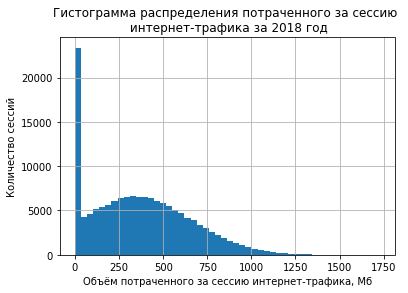

In [35]:
internet['mb_used'].hist(bins=50)
plt.title("Гистограмма распределения потраченного за сессию \n интернет-трафика за 2018 год")
plt.xlabel("Объём потраченного за сессию интернет-трафика, Мб")
plt.ylabel("Количество сессий")
plt.show()

Видно, что в течение многих сессий было загружено 0 Мб. Оценим их количество - абсолютное и относительное:

In [36]:
len(internet.query('mb_used == 0')), (len(internet) - len(internet.query('mb_used > 0'))) / len(calls)

(19598, 0.09672913571594269)

После первоначального знакомства с таблицей internet можно сделать следующие заключения:
- в таблице 5 столбцов и 149 396 строк;
- столбец 'Unnamed: 0' не содержит никакой полезной информации, он просто дублирует индексы строк. Этот столбец нужно будет удалить;
- в течение 19 598 сессий (или 10%) не было загружено ни одного Мб;
- средний объём потраченного за сессию трафика (с учетом "нулевых" сессий) - 370 Мб;
- распределение потраченного трафика состоявшихся интернет-сессий похоже на распределение Пуассона;
- в столбце user_id только 497 уникальных клиента, то есть оставшиеся 3 клиента из 500 не использовали интернет в течение года;
- больше всего сессий было совершено 31 декабря - накануне нового года.

#### 2. Предобработка данных <a class="anchor" id="2"></a>

#### Обработка столбцов с датами  <a class="anchor" id="2.1"></a>

В исследовании мы будем оценивать поведение пользователей от месяца к месяцу. Полные даты их действий не нужны, достаточно сохранить только номер месяца.

Напишем функцию, которая добавляет в таблицу столбец с месяцем действия и удаляет столбец с полной датой действия: 

In [37]:
def action_month(df, action_month, action_date):
    df[action_month] = pd.DatetimeIndex(df[action_date]).month
    del df[action_date]

А теперь применим эту функцию для соответствующих столбцов в каждой таблице:

In [38]:
action_month(users, 'reg_month', 'reg_date')
action_month(users, 'churn_month', 'churn_date')
action_month(calls, 'month', 'call_date')
action_month(internet, 'month', 'session_date')
action_month(messages, 'month', 'message_date')

Проверим, что функция сработала на примере одной из таблиц:

In [39]:
calls.sample()

,id,duration,user_id,month
154235,1382_18,8.79,1382,7


Теперь у нас есть столбец с номером месяца действия. Это упростит анализ данных.

#### Округление столбцов с продолжительностью звонков и интернет-трафиком  <a class="anchor" id="2.8"></a>

«Мегалайн» всегда округляет вверх значения минут и мегабайтов. Если пользователь проговорил всего 1 секунду, в тарифе засчитывается целая минута. Округлим значения продолжительности звонков и скачанных мегабайтов в большую сторону.

Запомним значение продолжительности для любого состоявшегося звонка и интернет трафика для любой состоявшейся сессии:

In [40]:
calls.loc[2290, 'duration']

5.54

In [41]:
internet.loc[86181, 'mb_used']

237.32

Округлим значения продолжительности звонков и скачанных мегабайтов в большую сторону:

In [42]:
calls['duration'] = calls['duration'].apply(np.ceil)
internet['mb_used'] = internet['mb_used'].apply(np.ceil)

Проверим, что значения округлились в большую сторону:

In [43]:
calls.loc[2290, 'duration']

6.0

In [44]:
internet.loc[86181, 'mb_used']

238.0

Округление сработало верно.

#### Удаление ненужных столбцов <a class="anchor" id="2.2"></a>

Как мы выяснили при знакомстве с данными, в таблице internet есть столбец 'Unnamed: 0', который просто дублирует индексы и сам по себе не несёт никакого смысла. Удалим его из таблицы:

In [45]:
del internet['Unnamed: 0']

Проверим, что столбец удалён:

In [46]:
internet.sample()

,id,mb_used,user_id,month
93490,1315_169,68.0,1315,9


#### Расчёт количества звонков для каждого пользователя <a class="anchor" id="2.3"></a>

Составим сводную таблицу, в которой можно увидеть для каждого пользователя количество звонков по месяцам:

In [47]:
calls_count = calls.pivot_table(index='user_id', columns='month', values='duration', aggfunc='count')

Напишем функцию, которая заполнит пропущенные значения в сводной таблице нулями и добавит в таблицу клиентов, у которых не было действий (для них будут нули в таблице по всем месяцам): 

In [48]:
def improve(df):
    df.reset_index(inplace=True)
    df.set_index('user_id', inplace=True)
    df.columns = [i for i in range(1, 13)]
    return df

In [49]:
calls_count = improve(calls_count)
calls_count.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,43.0,47.0,52.0,58.0,57.0,43.0,46.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,59.0,63.0
1002,NaN,NaN,NaN,NaN,NaN,15.0,26.0,42.0,36.0,33.0,32.0,33.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,55.0,134.0,108.0,115.0,108.0
1004,NaN,NaN,NaN,NaN,9.0,31.0,22.0,19.0,26.0,29.0,19.0,21.0


Сделаем проверку, построена ли сводная таблица верно. Сравним значение для одного из пользователей в один из месяцев с данными из таблицы calls:

In [50]:
if calls_count.loc[1004, 9] == len(calls.query('user_id == 1004 and month == 9')):
    print('Сводная таблица построена верно')
else:
    print('Где-то ошибка')

Сводная таблица построена верно


Таким образом, мы посчитали для каждого пользователя количество сделанных звонков по месяцам. Из таблицы легко получить количество звонков клиента в выбранный месяц - достаточно указать id клиента и номер месяца:

In [51]:
calls_count.loc[1002, 11]

32.0

#### Расчёт израсходованных минут для каждого пользователя <a class="anchor" id="2.4"></a>

Составим сводную таблицу, в которой можно увидеть для каждого пользователя количество израсходованных минут по месяцам:

In [52]:
calls_sum = calls.pivot_table(index='user_id', columns='month', values='duration', aggfunc='sum')

In [53]:
calls_sum = improve(calls_sum)
calls_sum.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,159.0,172.0,340.0,408.0,466.0,350.0,338.0,333.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,430.0,414.0
1002,NaN,NaN,NaN,NaN,NaN,117.0,214.0,289.0,206.0,212.0,243.0,236.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,380.0,961.0,855.0,824.0,802.0
1004,NaN,NaN,NaN,NaN,35.0,171.0,135.0,137.0,117.0,145.0,117.0,130.0


Таким образом, мы посчитали для каждого пользователя количество израсходованных минут по месяцам. Из таблицы легко получить количество минут звонка клиента в выбранный месяц - достаточно указать id клиента и номер месяца:

In [54]:
calls_sum.loc[1002, 11]

243.0

#### Расчёт количества отправленных сообщений для каждого пользователя <a class="anchor" id="2.5"></a>

Составим сводную таблицу, в которой можно увидеть для каждого пользователя количество отправленных сообщений по месяцам:

In [55]:
messages_count = messages.pivot_table(index='user_id', columns='month', aggfunc='count')

In [56]:
messages_count = improve(messages_count)
messages_count.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,22.0,60.0,75.0,81.0,57.0,73.0,58.0,70.0
1002,NaN,NaN,NaN,NaN,NaN,4.0,11.0,13.0,4.0,10.0,16.0,12.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,37.0,91.0,83.0,94.0,75.0
1004,NaN,NaN,NaN,NaN,95.0,134.0,181.0,151.0,146.0,165.0,158.0,162.0
1005,7.0,38.0,56.0,41.0,42.0,47.0,56.0,64.0,52.0,44.0,51.0,54.0


Сделаем проверку, построена ли сводная таблица верно. Сравним значение для одного из пользователей в один из месяцев с данными из таблицы messages:

In [57]:
if messages_count.loc[1003, 8] == len(messages.query('user_id==1003 and month==8')):
    print('Сводная таблица построена верно')
else:
    print('Где-то ошибка')

Сводная таблица построена верно


Таким образом, мы посчитали для каждого пользователя количество отправленных сообщений по месяцам. Из таблицы легко получить количество сообщений клиента в выбранный месяц - достаточно указать id клиента и номер месяца:

In [58]:
messages_count.loc[1002, 11]

16.0

#### Расчёт израсходованного трафика для каждого пользователя <a class="anchor" id="2.6"></a>

Составим сводную таблицу, в которой можно увидеть для каждого пользователя израсходованный трафик по месяцам:

In [59]:
internet_sum = internet.pivot_table(index='user_id', columns='month', values='mb_used', aggfunc='sum')

In [60]:
internet_sum = improve(internet_sum)
internet_sum.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,2256.0,23257.0,14016.0,14070.0,14581.0,14717.0,14768.0,9827.0
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,18452.0,14053.0
1002,NaN,NaN,NaN,NaN,NaN,10871.0,17601.0,20347.0,16712.0,13905.0,18610.0,18137.0
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,8571.0,12479.0,14779.0,11368.0,10132.0
1004,NaN,NaN,NaN,NaN,13415.0,17619.0,22243.0,28607.0,15125.0,18494.0,15631.0,18038.0


Сделаем проверку, построена ли сводная таблица верно. Сравним значение для одного из пользователей в один из месяцев с данными из таблицы internet:

In [61]:
if round(internet_sum.loc[1497, 10]) == round(internet.query('user_id==1497 and month==10')['mb_used'].sum()):
    print('Сводная таблица построена верно')
else:
    print('Где-то ошибка')

Сводная таблица построена верно


Таким образом, мы посчитали для каждого пользователя количество израсходованного трафика по месяцам. Из таблицы легко получить количество трафика клиента в выбранный месяц - достаточно указать id клиента и номер месяца:

In [62]:
internet_sum.loc[1002, 11]

18610.0

#### Расчёт выручки, полученной с каждого пользователя <a class="anchor" id="2.7"></a>

Составим сводную таблицу, в которой можно увидеть полученную выручку с каждого пользователя по месяцам. Как мы будем составлять такую таблицу:
1. Составим таблицы с потраченными минутами, сообщениями и трафиком по месяцам для каждого клиента;
2. Объединим эти таблицы в одну по id клиентов;
3. Добавим в получившуюся таблицу названия тарифов клиентов по их id;
4. Добавим в получившуюся таблицу условия тарифов по их названиям;
5. Добавим столбец earnings, где рассчитаем выручку для каждого клиента по месяцам.

Составим таблицы с потраченными минутами, сообщениями и трафиком по месяцам для каждого клиента:

In [63]:
calls_pivot = calls.pivot_table(index=['user_id', 'month'], values='duration', aggfunc='sum')
calls_pivot.reset_index(inplace=True)
calls_pivot.columns = ['user_id','month','calls_duration']
calls_pivot.head(1)

,user_id,month,calls_duration
0,1000,5,159.0


In [64]:
calls_pivot.shape

(3174, 3)

In [65]:
messages_pivot = messages.pivot_table(index=['user_id', 'month'], values='month', aggfunc='count')
messages_pivot.reset_index(inplace=True)
messages_pivot.columns = ['user_id','month','messages_count']
messages_pivot.head(1)

,user_id,month,messages_count
0,1000,5,22


In [66]:
messages_pivot.shape

(2717, 3)

In [67]:
internet_pivot = internet.pivot_table(index=['user_id', 'month'], values='mb_used', aggfunc='sum')
internet_pivot.reset_index(inplace=True)
internet_pivot.columns = ['user_id','month','mb_used']
internet_pivot.head(1)

,user_id,month,mb_used
0,1000,5,2256.0


In [68]:
internet_pivot.shape

(3203, 3)

In [69]:
users.shape

(500, 8)

Объединим эти таблицы в одну по id клиентов. Добавим в получившуюся таблицу названия тарифов клиентов и условия тарифов:

In [70]:
earnings = calls_pivot.merge(messages_pivot, on=['user_id', 'month'], how='outer')
earnings = earnings.merge(internet_pivot, on=['user_id', 'month'], how='outer')
earnings = earnings.merge(users[['user_id', 'tariff', 'city']], on=['user_id'], how='left')
earnings = earnings.merge(tariffs, left_on='tariff', right_on='tariff_name', how='left')
del earnings['tariff_name']
earnings = earnings.fillna(0)
earnings.sample(5)

,user_id,month,calls_duration,messages_count,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
894,1145,5,508.0,103.0,17282.0,smart,Тюмень,50,15360,500,550,200,3,3
532,1085,8,244.0,0.0,11805.0,ultra,Омск,1000,30720,3000,1950,150,1,1
2187,1352,4,412.0,4.0,7175.0,ultra,Рязань,1000,30720,3000,1950,150,1,1
3114,1490,4,270.0,38.0,13684.0,smart,Москва,50,15360,500,550,200,3,3
490,1078,9,1101.0,0.0,22794.0,ultra,Волгоград,1000,30720,3000,1950,150,1,1


Добавим в таблицу столбец earnings, где рассчитаем выручку для каждого клиента по месяцам:

In [71]:
def earnings_per_month(row):
    calls_earnings = (row['calls_duration'] - row['minutes_included']) * row['rub_per_minute']
    if calls_earnings < 0:
        calls_earnings = 0
    messages_earnings = (row['messages_count'] - row['messages_included']) * row['rub_per_message']
    if messages_earnings < 0:
        messages_earnings = 0  
    internet_earnings = (row['mb_used'] - row['mb_per_month_included']) * row['rub_per_gb'] / 1024
    if internet_earnings < 0:
        internet_earnings = 0          
    earnings = calls_earnings + messages_earnings + internet_earnings + row['rub_monthly_fee']
    return earnings

In [72]:
earnings['earnings'] = earnings.apply(earnings_per_month, axis=1)
earnings.sample(5)

,user_id,month,calls_duration,messages_count,mb_used,tariff,city,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,earnings
2424,1384,9,707.0,3.0,21748.0,smart,Нижний Новгород,50,15360,500,550,200,3,3,2418.656250
589,1094,10,868.0,28.0,17755.0,ultra,Новосибирск,1000,30720,3000,1950,150,1,1,1950.000000
1381,1219,5,467.0,13.0,17244.0,smart,Киров,50,15360,500,550,200,3,3,917.968750
1930,1308,8,337.0,23.0,13158.0,smart,Москва,50,15360,500,550,200,3,3,550.000000
1851,1295,10,156.0,108.0,19753.0,smart,Краснодар,50,15360,500,550,200,3,3,1582.007812


Посчитаем количество уникальных клиентов в таблице:

In [73]:
earnings['user_id'].nunique()

498

Получается, что 2 клиента из 500 не сделали ни одного звонка, не отправили ни одного сообщения и не сделали ни одной интернет-сессии за год.

Развернём таблицу так, чтобы можно было удобно находить выручку клиента по его id и номеру месяца:

In [74]:
earnings_sum = earnings.pivot_table(index='user_id', columns='month', values='earnings', aggfunc='sum')
earnings_sum = improve(earnings_sum)
earnings_sum.head()

,1,2,3,4,5,6,7,8,9,10,11,12
user_id,,,,,,,,,,,,
1000,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.000000,1950.000000,1950.0000,1950.0,1950.000000,1950.000000
1001,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1153.906250,550.000000
1002,NaN,NaN,NaN,NaN,NaN,550.0,987.695312,1524.023438,814.0625,550.0,1184.765625,1092.382812
1003,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1950.000000,1950.0000,1950.0,1950.000000,1950.000000
1004,NaN,NaN,NaN,NaN,1950.0,1950.0,1950.000000,1950.000000,1950.0000,1950.0,1950.000000,1950.000000


Таким образом, мы посчитали для каждого пользователя количество принесённой им выручки по месяцам. Из таблицы легко получить выручку с клиента в выбранный месяц - достаточно указать id клиента и номер месяца:

In [75]:
earnings_sum.loc[1002, 11]

1184.765625

#### 3. Анализ данных <a class="anchor" id="3"></a>

####  Динамика изменения количества клиентов по месяцам <a class="anchor" id="3.2"></a>

Оценим, как менялось количество клиентов разных тарифов в течение года. Посмотрим, в какие месяцы больше всего было подключено новых клиентов, а в какие - клиенты отключали тариф. Напишем функцию для построения графиков:

In [76]:
def plot(tariff):
    ax = users[users['tariff'] == tariff].plot(kind='hist', y='reg_month', histtype='step', 
                bins=12, linewidth=5, alpha=0.7, label='новые')
    users[users['tariff'] == tariff].plot(kind='hist', y='churn_month', histtype='step', bins=12, 
           linewidth=5, alpha=0.7, label='ушедшие', ax=ax, grid=True, legend=True)
    plt.title(f"Новые и ушедшие клиенты тарифа {tariff}")
    plt.xlabel("Месяц")
    plt.ylabel("Количество клиентов")
    plt.show()

Посторим графики для тарифов:

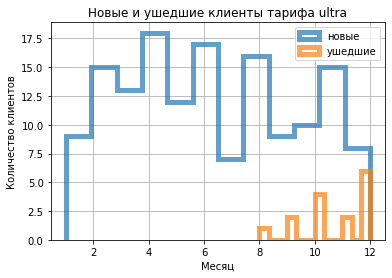

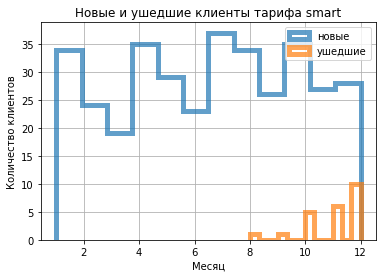

In [77]:
plot('ultra')
plot('smart')

К обоим тарифам в течение года равномерно подключались новые клиенты, а прекращали пользоваться тарифами только ближе к концу. Оба тарифа имеют схожую картину распределения по этим показателям.

#### Топ городов по количеству клиентов <a class="anchor" id="3.3"></a>

Посмотрим, из каких городов больше всего клиентов. Выведем топ-5 городов:

In [78]:
cities = users.groupby('city')['user_id'].count().reset_index().sort_values('user_id', ascending=False)
cities.columns = ['city', 'users']
cities.head()

,city,users
31,Москва,99
50,Санкт-Петербург,39
39,Новосибирск,16
18,Казань,14
40,Омск,14


Построим гистограмму с топ-10 городов по количеству клиентов:

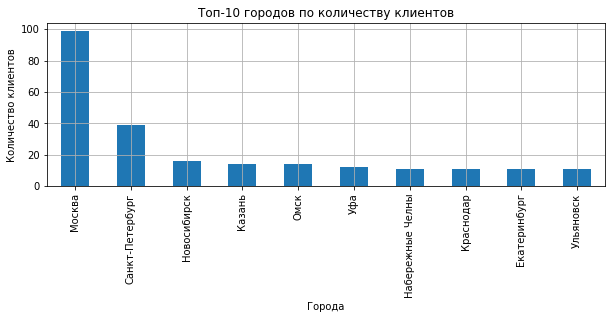

In [79]:
cities.head(10).plot(kind='bar', x='city', y='users', grid=True, legend=False, figsize=(10, 3))
plt.title('Топ-10 городов по количеству клиентов')
plt.xlabel("Города")
plt.ylabel("Количество клиентов")
plt.show()

Больше всего клиентов из Москвы (99 человек), на втором месте Питер (39). Дальше идёт ряд городов, где примерно одинаковое количество клиентов.

#### Взаимосвязь тарифа и продолжительности звонков  <a class="anchor" id="3.4"></a>

Для начала исключим из таблицы calls все звонки, которые длились 0 минут. Это несостоявшиеся звонки, их мы рассматривать не будем.

In [80]:
calls_filtered = calls.query('duration > 0')

Добавим в таблицу столбец с тарифом пользователя:

In [81]:
calls_filtered = calls_filtered.merge(users[['user_id', 'tariff']], on='user_id')
calls_filtered.head(5)

,id,duration,user_id,month,tariff
0,1000_2,3.0,1000,6,ultra
1,1000_3,14.0,1000,9,ultra
2,1000_4,6.0,1000,12,ultra
3,1000_7,19.0,1000,8,ultra
4,1000_8,19.0,1000,9,ultra


Построим гистограммы продолжительности звонков в зависимости от тарифа:

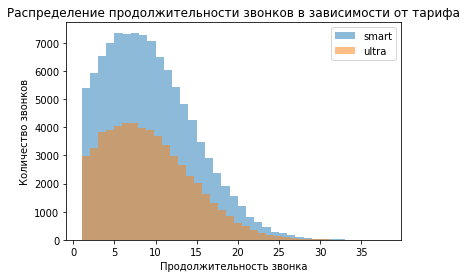

In [82]:
ax = calls_filtered.query('tariff == "smart"')['duration'].plot(kind='hist', bins=37, 
                                                                label='smart', grid=True, alpha=0.5, legend=True)
calls_filtered.query('tariff == "ultra"')['duration'].plot(kind='hist', bins=37, alpha=0.5, ax=ax, 
                                                           label='ultra', legend=True)
plt.title("Распределение продолжительности звонков в зависимости от тарифа")
plt.xlabel("Продолжительность звонка")
plt.ylabel("Количество звонков")
plt.show()

Распределения соответствуют распределению Пуассона. Можно заметить, что моды гистограмм находятся примерно на одной продолжительности звонка - то есть продолжительность не зависит от тарифа. В целом гистограммы идентичны, различие только в количестве звонков (высоте гистограмм). Это связано с тем, что клиентов тарифа smart больше, чем клиентов тарифа ultra.

Напишем функцию, которая будет определять среднее значение, дисперсию и среднеквадратичное отклонение исходя из тарифа.

In [83]:
def statistics(df, column):
    print('Тариф smart:')
    print('Среднее значение:', df.query('tariff == "smart"')[column].mean())
    print('Дисперсия:', np.var(df.query('tariff == "smart"')[column], ddof=1))
    print('Среднеквадратичное отклонение:', np.std(df.query('tariff == "smart"')[column], ddof=1))
    print()
    print('Тариф ultra:')
    print('Среднее значение:', df.query('tariff == "ultra"')[column].mean())
    print('Дисперсия:', np.var(df.query('tariff == "ultra"')[column], ddof=1))
    print('Среднеквадратичное отклонение:', np.std(df.query('tariff == "ultra"')[column], ddof=1))

In [84]:
statistics(calls_filtered, 'duration')

Тариф smart:
Среднее значение: 8.902174951742063
Дисперсия: 28.60929394601733
Среднеквадратичное отклонение: 5.348765646952326

Тариф ultra:
Среднее значение: 8.890176184273669
Дисперсия: 28.75904929111738
Среднеквадратичное отклонение: 5.3627464317378815


Средние значения продолжительности звонков оказались практически идентичными, как и меры изменчивости. Можно заключить, что поведение клиентов, связанное со звонками, не зависит от тарифа, которым они пользуются.

#### Взаимосвязь тарифа и количества отправленных сообщений  <a class="anchor" id="3.5"></a>

Составим таблицу с количествами сообщений в месяц для каждого пользователя и добавим в неё столбец с тарифом пользователя:

In [85]:
messages_filtered = messages.groupby(['user_id', 'month'])['id'].count().reset_index()
messages_filtered = messages_filtered.merge(users[['user_id', 'tariff']], on='user_id')
messages_filtered.columns = ['user_id', 'month', 'messages_per_month', 'tariff']
messages_filtered.head()

,user_id,month,messages_per_month,tariff
0,1000,5,22,ultra
1,1000,6,60,ultra
2,1000,7,75,ultra
3,1000,8,81,ultra
4,1000,9,57,ultra


Построим гистограммы количества отправленных сообщений в месяц в зависимости от тарифа:

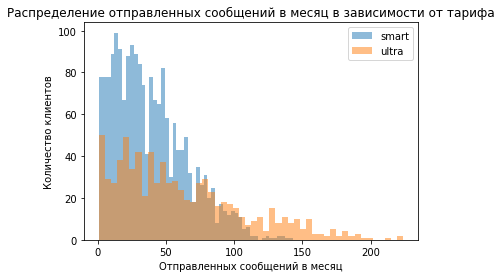

In [86]:
ax = messages_filtered.query('tariff == "smart"')['messages_per_month'].plot(kind='hist', bins=50, 
                                                             label='smart', grid=True, alpha=0.5, legend=True)
messages_filtered.query('tariff == "ultra"')['messages_per_month'].plot(kind='hist', bins=50, 
                                                        alpha=0.5, ax=ax, label='ultra', legend=True)
plt.title("Распределение отправленных сообщений в месяц в зависимости от тарифа")
plt.xlabel("Отправленных сообщений в месяц")
plt.ylabel("Количество клиентов")
plt.show()

Распределения похожи на распределение Пуассона. Моды распределений находятся примерно в одном диапазоне - от 0 до 50 сообщений в месяц. То есть наиболее частое поведение клиентов, связанное с отправкой сообщений, не зависит от тарифа. Однако можно заметить, что хвост гистограммы тарифа ultra длиннее, чем хвост гистограммы тарифа smart - это говорит о том, что среди нашей выборки клиенты тарифа ultra чаще отправляют большое количество (больше 100) сообщений в месяц.

In [87]:
statistics(messages_filtered, 'messages_per_month')

Тариф smart:
Среднее значение: 38.71644120707596
Дисперсия: 717.5942011753547
Среднеквадратичное отклонение: 26.787948804926344

Тариф ultra:
Среднее значение: 61.161006289308176
Дисперсия: 2109.6591828652
Среднеквадратичное отклонение: 45.931026364160424


Ожидаемо, распределение сообщений для тарифа ultra имеет бóльшие меры изменчивости. А так как это распределение Пуассона, то длинный правый хвост тянет за собой и среднее значение. Оно оказывается тоже значительно больше, чем для тарифа smart, хотя моды находятся примерно на одном значении.

#### Взаимосвязь тарифа и интернет-трафика за одну сессию  <a class="anchor" id="3.6"></a>

Для начала исключим из таблицы internet все сессии, за которые было скачано 0 Мб. Это несостоявшиеся сессии, они не связаны непосредственно с тарифом. Также добавим столбец с тарифом пользователя.

In [88]:
internet_filtered = internet.query('mb_used > 0')
internet_filtered = internet_filtered.merge(users[['user_id', 'tariff']], on='user_id')

Построим гистограммы интернет-трафика за сессию в зависимости от тарифа:

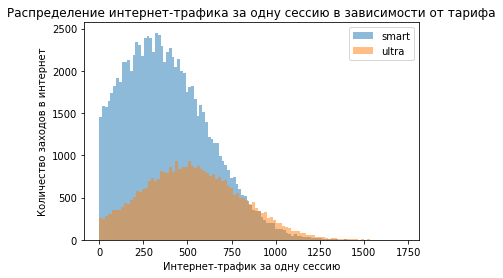

In [89]:
ax = internet_filtered.query('tariff == "smart"')['mb_used'].plot(kind='hist', bins=100, 
                                                                label='smart', grid=True, alpha=0.5, legend=True)
internet_filtered.query('tariff == "ultra"')['mb_used'].plot(kind='hist', bins=100, alpha=0.5, ax=ax, 
                                                           label='ultra', legend=True)
plt.title("Распределение интернет-трафика за одну сессию в зависимости от тарифа")
plt.xlabel("Интернет-трафик за одну сессию")
plt.ylabel("Количество заходов в интернет")
plt.show()

Распределения соответствуют распределению Пуассона. Можно заметить, что мода гистограммы тарифа ultra смещена чуть вправо относительно моды гистограммы тарифа smart - это говорит о том, что среди нашей выборки клиенты тарифа ultra скачивают больше Мб за одну сессию.

In [90]:
statistics(internet_filtered, 'mb_used')

Тариф smart:
Среднее значение: 386.0051752102096
Дисперсия: 56366.12833047028
Среднеквадратичное отклонение: 237.41551830171144

Тариф ultra:
Среднее значение: 531.971564769137
Дисперсия: 73228.07729346342
Среднеквадратичное отклонение: 270.60686852602873


Среднее значение интернет-трафика для тарифа ultra ожидаемо больше, чем для тарифа smart. Меры изменчивости также больше.

#### 4. Проверка гипотез <a class="anchor" id="4"></a>

#### Средняя выручка клиентов тарифов «Ультра» и «Смарт» различается <a class="anchor" id="4.1"></a>

Сформулируем гипотезы:
- Нулевая гипотеза: Средняя выручка клиентов тарифов «Ультра» и «Смарт» не различается.
- Альтернативная гипотеза: Средняя выручка клиентов тарифов «Ультра» и «Смарт» различается.

Примем, что нулевая гипотеза верна. Согласно ЦПТ, если из генеральной совокупности (независимо от формы её распределения) многократно и произвольно извлекать две выборки, то разности средних этих выборок будут располагаться нормально вокруг нуля (при условии, что верна нулевая гипотеза). Если расстояние между разностью средних двух выборок, которые мы сравниваем между собой, и нулём окажется более 2 ошибок среднего (для порогового значения альфа = 0,05), то можно будет отвергнуть нулевую гипотезу. Проведём рассчёт.

Зададим две выборки: выручки клиентов с тарифом smart и клиентов с тарифом ultra.

In [91]:
sample_smart = earnings.query('tariff == "smart"')['earnings']
sample_ultra = earnings.query('tariff == "ultra"')['earnings']

Посчитаем стандартные отклонения в выборках, ошибку среднего и Т-критерий Стьюдента для независимых выборок:

In [92]:
sd_smart = np.std(sample_smart, ddof=1)
sd_ultra = np.std(sample_ultra, ddof=1)

se = ((sd_smart**2) / len(sample_smart) + (sd_ultra**2) / len(sample_ultra))**0.5
t = (stat.mean(sample_ultra) - stat.mean(sample_smart)) / se
t

40.989667506060194

t-критерий показывает насколько отклонилась разность между средними двух выборок от нуля. Значение измеряется в количестве ошибок среднего. Зная t-критерий, можно найти вероятность того, что нулевая гипотеза верна. Для этого есть специальные таблицы и сайты, например: https://gallery.shinyapps.io/dist_calc/. Однако, t-критерия, равного 41 там нет. Это слишком большое значение. Это означает, что с практически 100% уверенностью можно отклонить нулевую гипотезу и принять альтернативную.

Рассчитать вероятность иметь такое различие в средних выборок при условии, что верна нулевая гипотеза, (p-уровень значимости) можно специальным методом ttest_ind библиотеки scipy. Напишем функцию, которая будет принимать выборки и пороговое значение альфа и возвращать верную гипотезу:

In [93]:
def hypo_test(sample_1, sample_2, alpha):
    results = st.ttest_ind(sample_1, sample_2, equal_var=False)
    print(f'Значение p-уровня значимости: {results.pvalue}')
    if results.pvalue < alpha:
        print('Альтернативная гипотеза верна')
    else:
        print('Нулевая гипотеза верна')

In [94]:
hypo_test(sample_smart, sample_ultra, .05)

Значение p-уровня значимости: 8.931402711368788e-296
Альтернативная гипотеза верна


Встроенный метод ttest_ind также рассчитал нам, что верна альтернативная гипотеза. 

Оценим визуально распределение выручки тарифа smart и тарифа ultra:

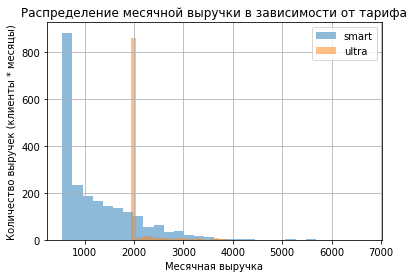

In [95]:
ax = earnings.query('tariff == "smart"')['earnings'].plot(kind='hist', bins=30,
                                                             label='smart', grid=True, alpha=0.5, legend=True)
earnings.query('tariff == "ultra"')['earnings'].plot(kind='hist', bins=30,
                                                        alpha=0.5, ax=ax, label='ultra', legend=True, grid=True)
plt.title("Распределение месячной выручки в зависимости от тарифа")
plt.xlabel("Месячная выручка")
plt.ylabel("Количество выручек (клиенты * месяцы)")
plt.show()

In [96]:
statistics(earnings, 'earnings')

Тариф smart:
Среднее значение: 1233.3494665489009
Дисперсия: 620452.6075337975
Среднеквадратичное отклонение: 787.6881410392043

Тариф ultra:
Среднее значение: 2060.5299710501267
Дисперсия: 126953.28545993957
Среднеквадратичное отклонение: 356.3050455156923


На гистограмме также видно, что распределения сильно смещены друг относительно друга. Как следствие их средние сильно отличаются.

Можно заключить практически со 100% уверенностью, что средняя выручка клиентов тарифов «Ультра» и «Смарт» различается. 

#### Cредняя выручка клиентов из Москвы отличается от выручки клиентов из других регионов <a class="anchor" id="4.2"></a>

Построим гистограмму средних месячных выручек в зависимости от города:

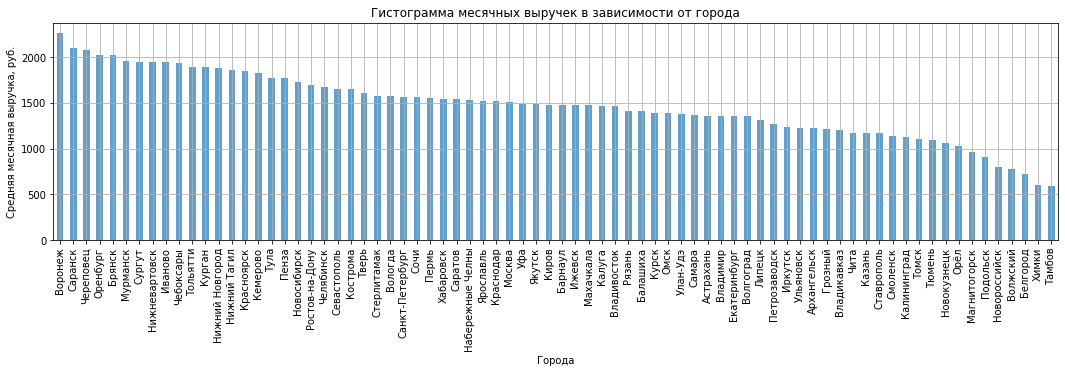

In [97]:
earnings_city = earnings.pivot_table(index='city', values='earnings').reset_index()
earnings_city.columns = ['city', 'earnings_mean']
earnings_city.sort_values('earnings_mean', ascending=False, inplace=True)
earnings_city.plot(kind='bar', x='city', y='earnings_mean', legend=False, figsize=(18, 4), grid=True, alpha=0.7)
plt.title("Гистограмма месячных выручек в зависимости от города")
plt.xlabel("Города")
plt.ylabel("Средняя месячная выручка, руб.")
plt.show()

Видно, что средние выручки отличаются среди городов. Сравним среднюю выручку в Москве с выручкой в других городах.

Сформулируем гипотезы:
- Нулевая гипотеза: Cредняя выручка клиентов из Москвы не отличается от выручки клиентов из других регионов.
- Альтернативная гипотеза: Cредняя выручка клиентов из Москвы отличается от выручки клиентов из других регионов.

Примем, что нулевая гипотеза верна. Если средние выручки клиентов из Москвы и других регионов не различаются в генеральной совокупности, то расстояние между разностью их средних и нулём будет менее двух ошибок среднего (для порогового значения альфа = 0,05). Проведём рассчёт.

Зададим две выборки: выручки клиентов из Москвы и других регионов.

In [98]:
sample_msc = earnings.query('city == "Москва"')['earnings']
sample_other = earnings.query('city != "Москва"')['earnings']

Посчитаем стандартные отклонения в выборках, ошибку среднего и Т-критерий Стьюдента для независимых выборок:

In [99]:
sd_msc = np.std(sample_msc, ddof=1)
sd_other = np.std(sample_other, ddof=1)
se = ((sd_msc**2) / len(sample_msc) + (sd_other**2) / len(sample_other))**0.5
t = (stat.mean(sample_msc) - stat.mean(sample_other)) / se
t

0.7474432731918049

Рассчитаем p-уровень значимости по специальному сайту для t-критерия, равного 0,74: https://gallery.shinyapps.io/dist_calc/. Он равняется около 0,46 или 46%. 

Проверим с помощью встроенного метода ttest_ind:

In [100]:
hypo_test(sample_msc, sample_other, .05)

Значение p-уровня значимости: 0.4549775646471024
Нулевая гипотеза верна


Статистически значимых различий в средней выручке между клиентами из Москвы и клиентами из других регионов не найдено.

Найдём средние значения и меры изменчивости:

In [101]:
print("Москва")
print('Среднее значение:', earnings.query('city == "Москва"')['earnings'].mean())
print('Дисперсия:', np.var(earnings.query('city == "Москва"')['earnings'], ddof=1))
print('Среднеквадратичное отклонение:', np.std(earnings.query('city == "Москва"')['earnings'], ddof=1))
print()
print("Другие регионы")
print('Среднее значение:', earnings.query('city != "Москва"')['earnings'].mean())
print('Дисперсия:', np.var(earnings.query('city != "Москва"')['earnings'], ddof=1))
print('Среднеквадратичное отклонение:', np.std(earnings.query('city != "Москва"')['earnings'], ddof=1))

Москва
Среднее значение: 1507.276761968085
Дисперсия: 547242.7498927494
Среднеквадратичное отклонение: 739.7585754100788

Другие регионы
Среднее значение: 1482.0637267996062
Дисперсия: 630503.8546346537
Среднеквадратичное отклонение: 794.0427284691006


Средние значения близки.

Построим гистограммы выручек для Москвы и других регионов:

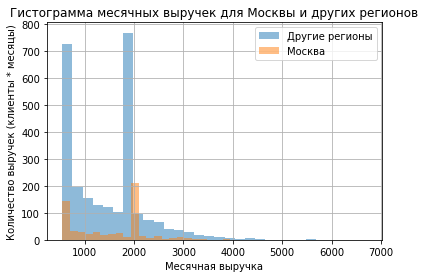

In [102]:
ax = earnings.query('city != "Москва"')['earnings'].plot(kind='hist', alpha=0.5, bins=30, 
                                                                  label='Другие регионы', legend=True)
earnings.query('city == "Москва"')['earnings'].plot(kind='hist', ax=ax, alpha=0.5, bins=30, 
                                                    label='Москва', legend=True, grid=True)
plt.title("Гистограмма месячных выручек для Москвы и других регионов")
plt.xlabel("Месячная выручка")
plt.ylabel("Количество выручек (клиенты * месяцы)")
plt.show()

По гистограммам видно, что они примерно идентичны. Отличаются только по высоте, что связано с различием в количестве клиентов - в общей сложности в регионах их больше, чем в одной только Москве. 

Заключим, что статически значимых различий в средней выручке между клиентами из Москвы и регионов не найдено.

#### 5. Общий вывод <a class="anchor" id="5"></a>

В ходе исследования была проведена следующая работа: 
- мы познакомились с поведением 500 клиентов оператора, которые пользовались тарифами «Ультра» и «Смарт» на протяжении всего 2018 года;
- выяснили, что среди клиентов выборки тарифом «Смарт» пользуются 351 человек, тарифом «Ультра» - 149;
- выяснили, что больше всего клиентов в выборке из Москвы (99 человек), на втором месте Питер (39 человек);
- выяснили, что к обоим тарифам в течение года равномерно подключались новые клиенты, а прекращали пользоваться тарифами только ближе к концу;
- для каждого клиента рассчитали количество потраченных минут звонков, отправленных сообщений, интернет-трафик и выручку по месяцам, организовали удобный доступ к данным по id клиента и номеру месяца;
- выяснили, что среди клиентов нашей выборки продолжительность звонков не зависит от тарифа, которым они пользуются;
- выяснили, что среди клиентов нашей выборки клиенты тарифа «Ультра» чаще отправляют большое количество (больше 100) сообщений в месяц, чем клиенты тарифа «Смарт»;
- выяснили, что среди клиентов нашей выборки клиенты тарифа «Ультра» скачивают больше Мб за одну сессию, чем клиенты тарифа «Смарт» (средние 532 Мб против 386 Мб);
- выяснили, что средние выручки клиентов тарифов «Ультра» и «Смарт» статистически значимо различаются - выручка клиентов тарифа «Ультра» больше;
- построили гистограмму средних выручек по городам среди клиентов из выборки;
- выяснили, что средняя выручка пользователей из Москвы статистически значимо не отличается от выручки пользователей из других регионов.